# Minimum variance portfolio on selected Danish stocks

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from port_opt import get_portf_rtn, get_portf_vol, get_optimal_portfolio, get_efficient_frontier, neg_sharpe_ratio

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('cubehelix')
plt.rcParams['figure.figsize'] = [5.5, 3]
plt.rcParams['figure.dpi'] = 200

np.random.seed(0)

## Preprocess and load the data

In [3]:
%run preprocessing.py -n DK -i stock

In [4]:
close_df = pd.read_csv('..\data\DK\preprocessed_data\danish_closed_stocks.csv', index_col=0)

In [5]:
# Constants
danish_2y_yield = 0.03463
stocks_names = close_df.columns.tolist()

dividends = {stock: 0 for stock in stocks_names}
dividends['ORSTED'] = 2.14 / 100
dividends['MAERSK'] = 27.53 / 100
dividends['VWS'] = 0.0
dividends['CHR'] = 1.63 / 100
dividends['NOVO'] = 1.32 / 100
dividends['NZYM'] = 1.71 / 100
dividends['DNORD'] = 10.77 / 100
dividends['TRMD'] = 16.52 / 100
dividends['STG'] = 6.76 / 100
dividends['SOLAR'] = 7.26 / 100
dividends['AOJ'] = 6.32 /100
dividends['SKAKO'] = 7.99 / 100

dividends = pd.Series(dividends)

In [6]:
close_df.head()

,AOJ,CHR,DNORD,MAERSK,NOVO,NZYM,ORSTED,SKAKO,SOLAR,STG,TRMD,VWS,ZEAL
2016-06-09 09:00:00+02:00,17.419270,369.411660,64.130959,5045.532146,321.379956,279.415738,226.444085,46.989652,215.004439,68.773193,48.681280,86.325277,123.5
2016-06-10 09:00:00+02:00,17.542520,361.352082,61.591762,4903.035849,312.631414,273.018271,221.177944,45.784789,209.540948,68.394625,44.596138,83.535190,121.0
2016-06-13 09:00:00+02:00,17.534303,355.772390,59.508322,4801.252780,311.516413,272.657860,214.156422,44.178305,203.113311,66.880353,45.276995,81.842536,115.5
2016-06-14 09:00:00+02:00,17.534303,349.572722,58.434046,4580.238116,294.190878,267.521855,218.895940,42.973443,199.256729,66.249406,43.915281,79.926679,108.5
2016-06-15 09:00:00+02:00,17.534303,351.609747,59.573429,4676.205009,295.220125,272.207335,222.494479,45.784789,200.863639,66.375595,44.255709,80.428891,113.0


## EDA

In [7]:
returns_df = close_df.pct_change().dropna()
returns_df

,AOJ,CHR,DNORD,MAERSK,NOVO,NZYM,ORSTED,SKAKO,SOLAR,STG,TRMD,VWS,ZEAL
2016-06-10 09:00:00+02:00,0.007075,-0.021817,-0.039594,-0.028242,-0.027222,-0.022896,-0.023256,-0.025641,-0.025411,-0.005505,-0.083916,-0.032321,-0.020243
2016-06-13 09:00:00+02:00,-0.000468,-0.015441,-0.033827,-0.020759,-0.003567,-0.001320,-0.031746,-0.035088,-0.030675,-0.022140,0.015267,-0.020263,-0.045455
2016-06-14 09:00:00+02:00,0.000000,-0.017426,-0.018053,-0.046033,-0.055617,-0.018837,0.022131,-0.027273,-0.018987,-0.009434,-0.030075,-0.023409,-0.060606
2016-06-15 09:00:00+02:00,0.000000,0.005827,0.019499,0.020952,0.003499,0.017514,0.016439,0.065421,0.008065,0.001905,0.007752,0.006283,0.041475
2016-06-16 09:00:00+02:00,0.000000,0.015617,-0.026776,-0.027363,-0.016851,-0.020192,-0.010651,-0.035088,-0.035200,-0.013308,-0.007692,-0.022895,-0.048673
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-18 09:00:00+02:00,0.000000,0.012935,0.015300,0.022099,-0.007276,0.007564,0.003521,0.035211,0.006085,-0.020117,0.003236,0.017527,-0.025244
2023-07-19 09:00:00+02:00,-0.015248,0.009178,-0.011453,0.011892,0.000188,0.015616,-0.003190,-0.006803,-0.003024,-0.004277,-0.009032,0.010981,-0.007519
2023-07-20 09:00:00+02:00,0.025806,0.000791,0.001219,0.013533,0.037392,-0.006505,-0.032000,-0.013699,-0.004044,-0.004296,-0.009115,-0.007561,0.010101
2023-07-21 09:00:00+02:00,0.006289,-0.003161,-0.029842,-0.039002,0.004528,-0.006548,0.000661,0.013889,-0.005076,0.001726,-0.006570,0.005043,0.001667


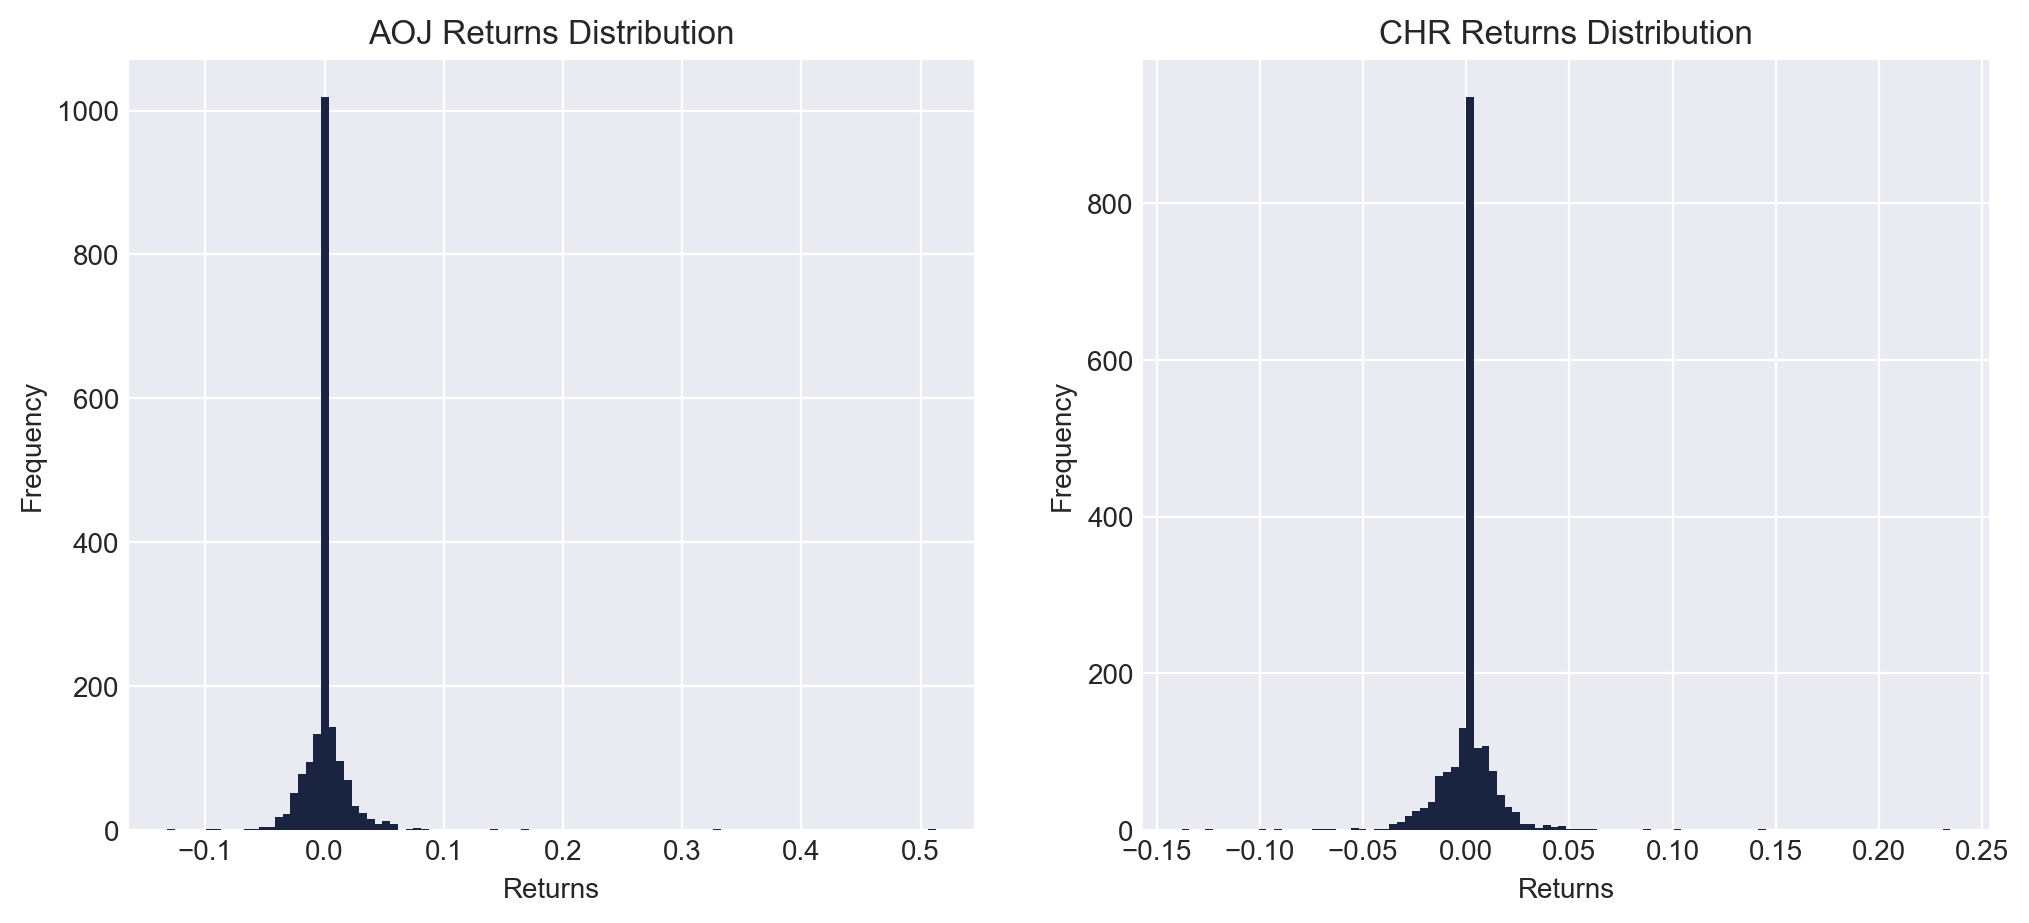

In [8]:
# Visuallize the returns distrubution of AOJ
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(returns_df.loc[:, 'AOJ'], bins=100)
axs[0].set(xlabel='Returns', ylabel='Frequency', title='AOJ Returns Distribution')

axs[1].hist(returns_df.loc[:, 'CHR'], bins=100)
axs[1].set(xlabel='Returns', ylabel='Frequency', title='CHR Returns Distribution')

plt.show()

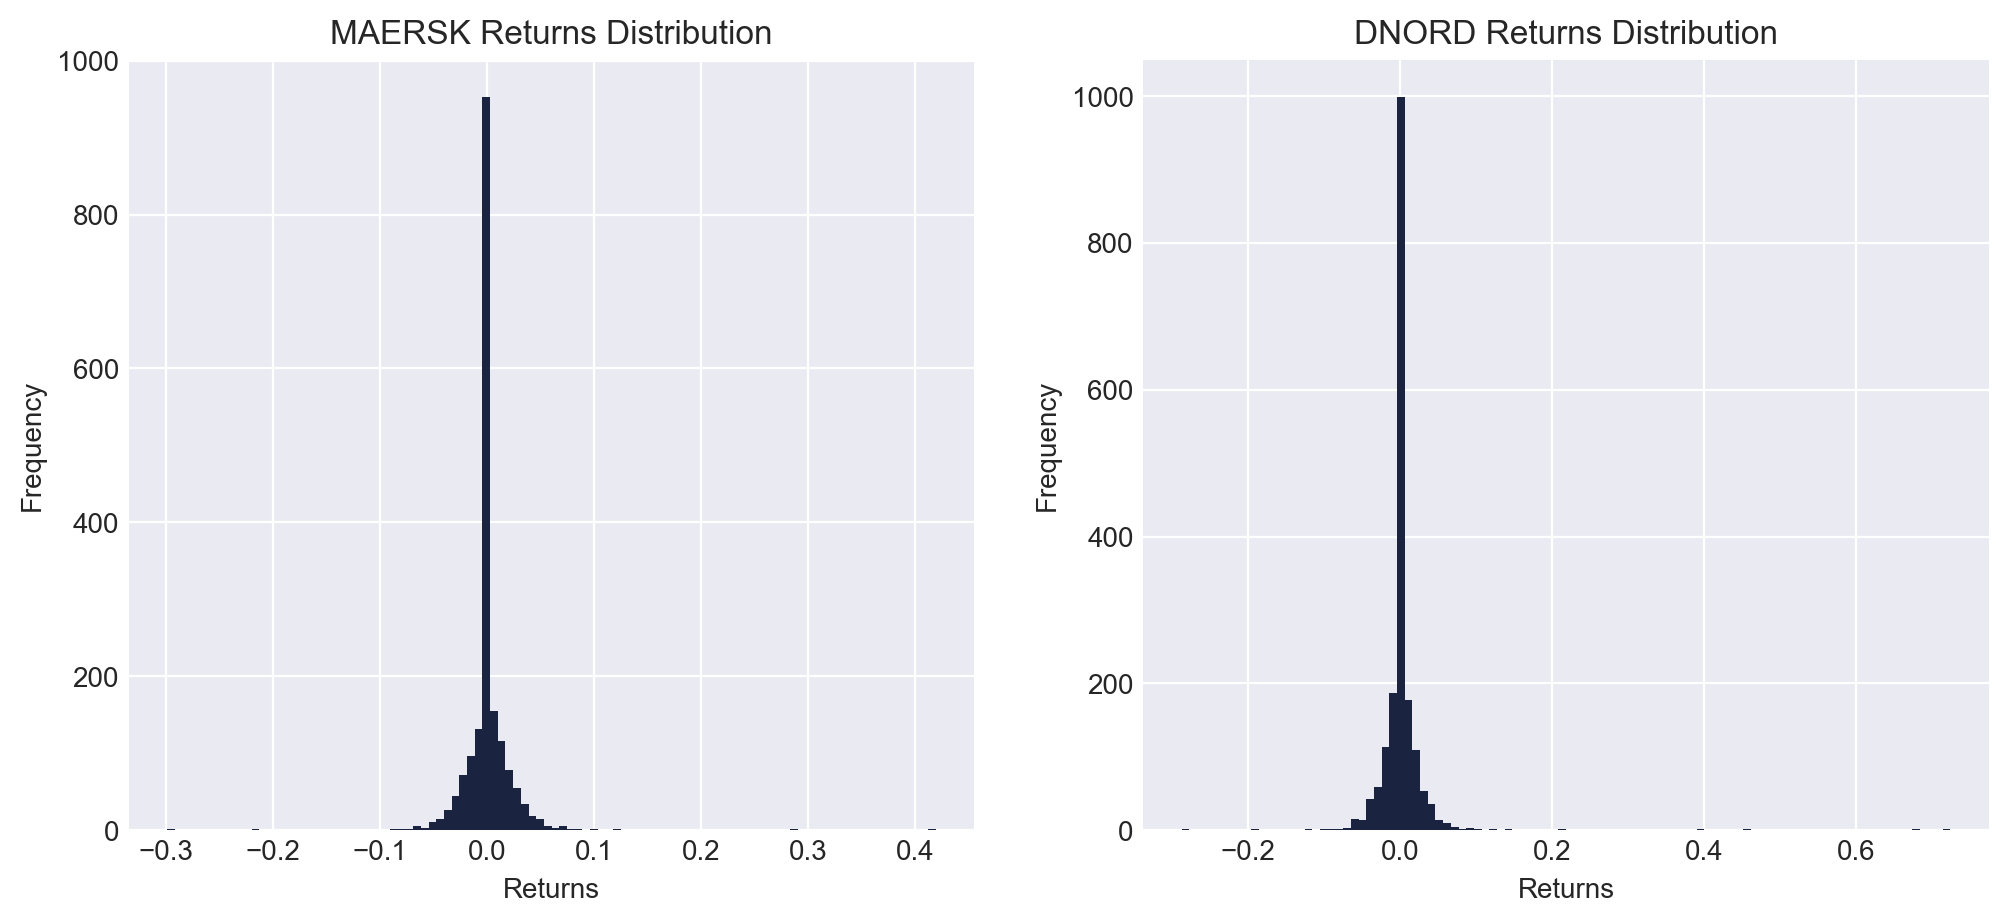

In [9]:
# Visuallize the returns distrubution of AOJ
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(returns_df.loc[:, 'MAERSK'], bins=100)
axs[0].set(xlabel='Returns', ylabel='Frequency', title='MAERSK Returns Distribution')

axs[1].hist(returns_df.loc[:, 'DNORD'], bins=100)
axs[1].set(xlabel='Returns', ylabel='Frequency', title='DNORD Returns Distribution')

plt.show()

### Correlation of the returns

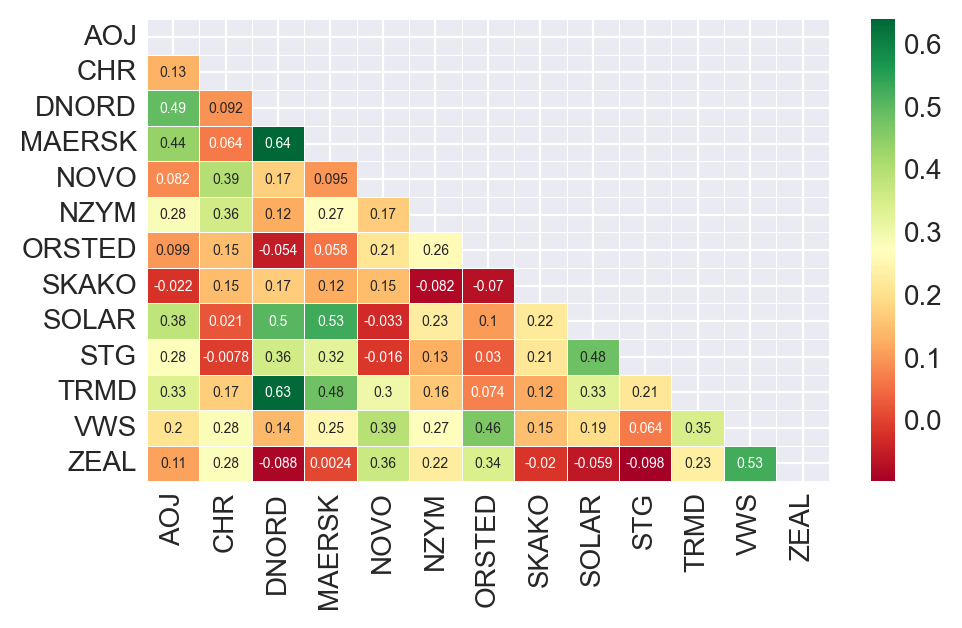

In [10]:
r_corr_matrix = returns_df.corr()

mask = np.zeros_like(r_corr_matrix)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(r_corr_matrix, annot=True, mask=mask, cmap='RdYlGn', linewidths=0.2, annot_kws={'size': 5});

## Portfolio optimization

In [11]:
n_days = 260
n_portfolios = 100000
n_assets = len(stocks_names)
avg_returns = returns_df.mean() * n_days
avg_returns = avg_returns + dividends
cov_matrix = returns_df.cov() * n_days

In [12]:
weights = np.random.random(size=(n_portfolios, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [13]:
portf_rtns = np.dot(weights, avg_returns)

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov_matrix, weights[i]))))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = (portf_rtns - danish_2y_yield) / portf_vol

In [14]:
portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio})

In [15]:
n_points = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                           n_points)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(n_points):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
    
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

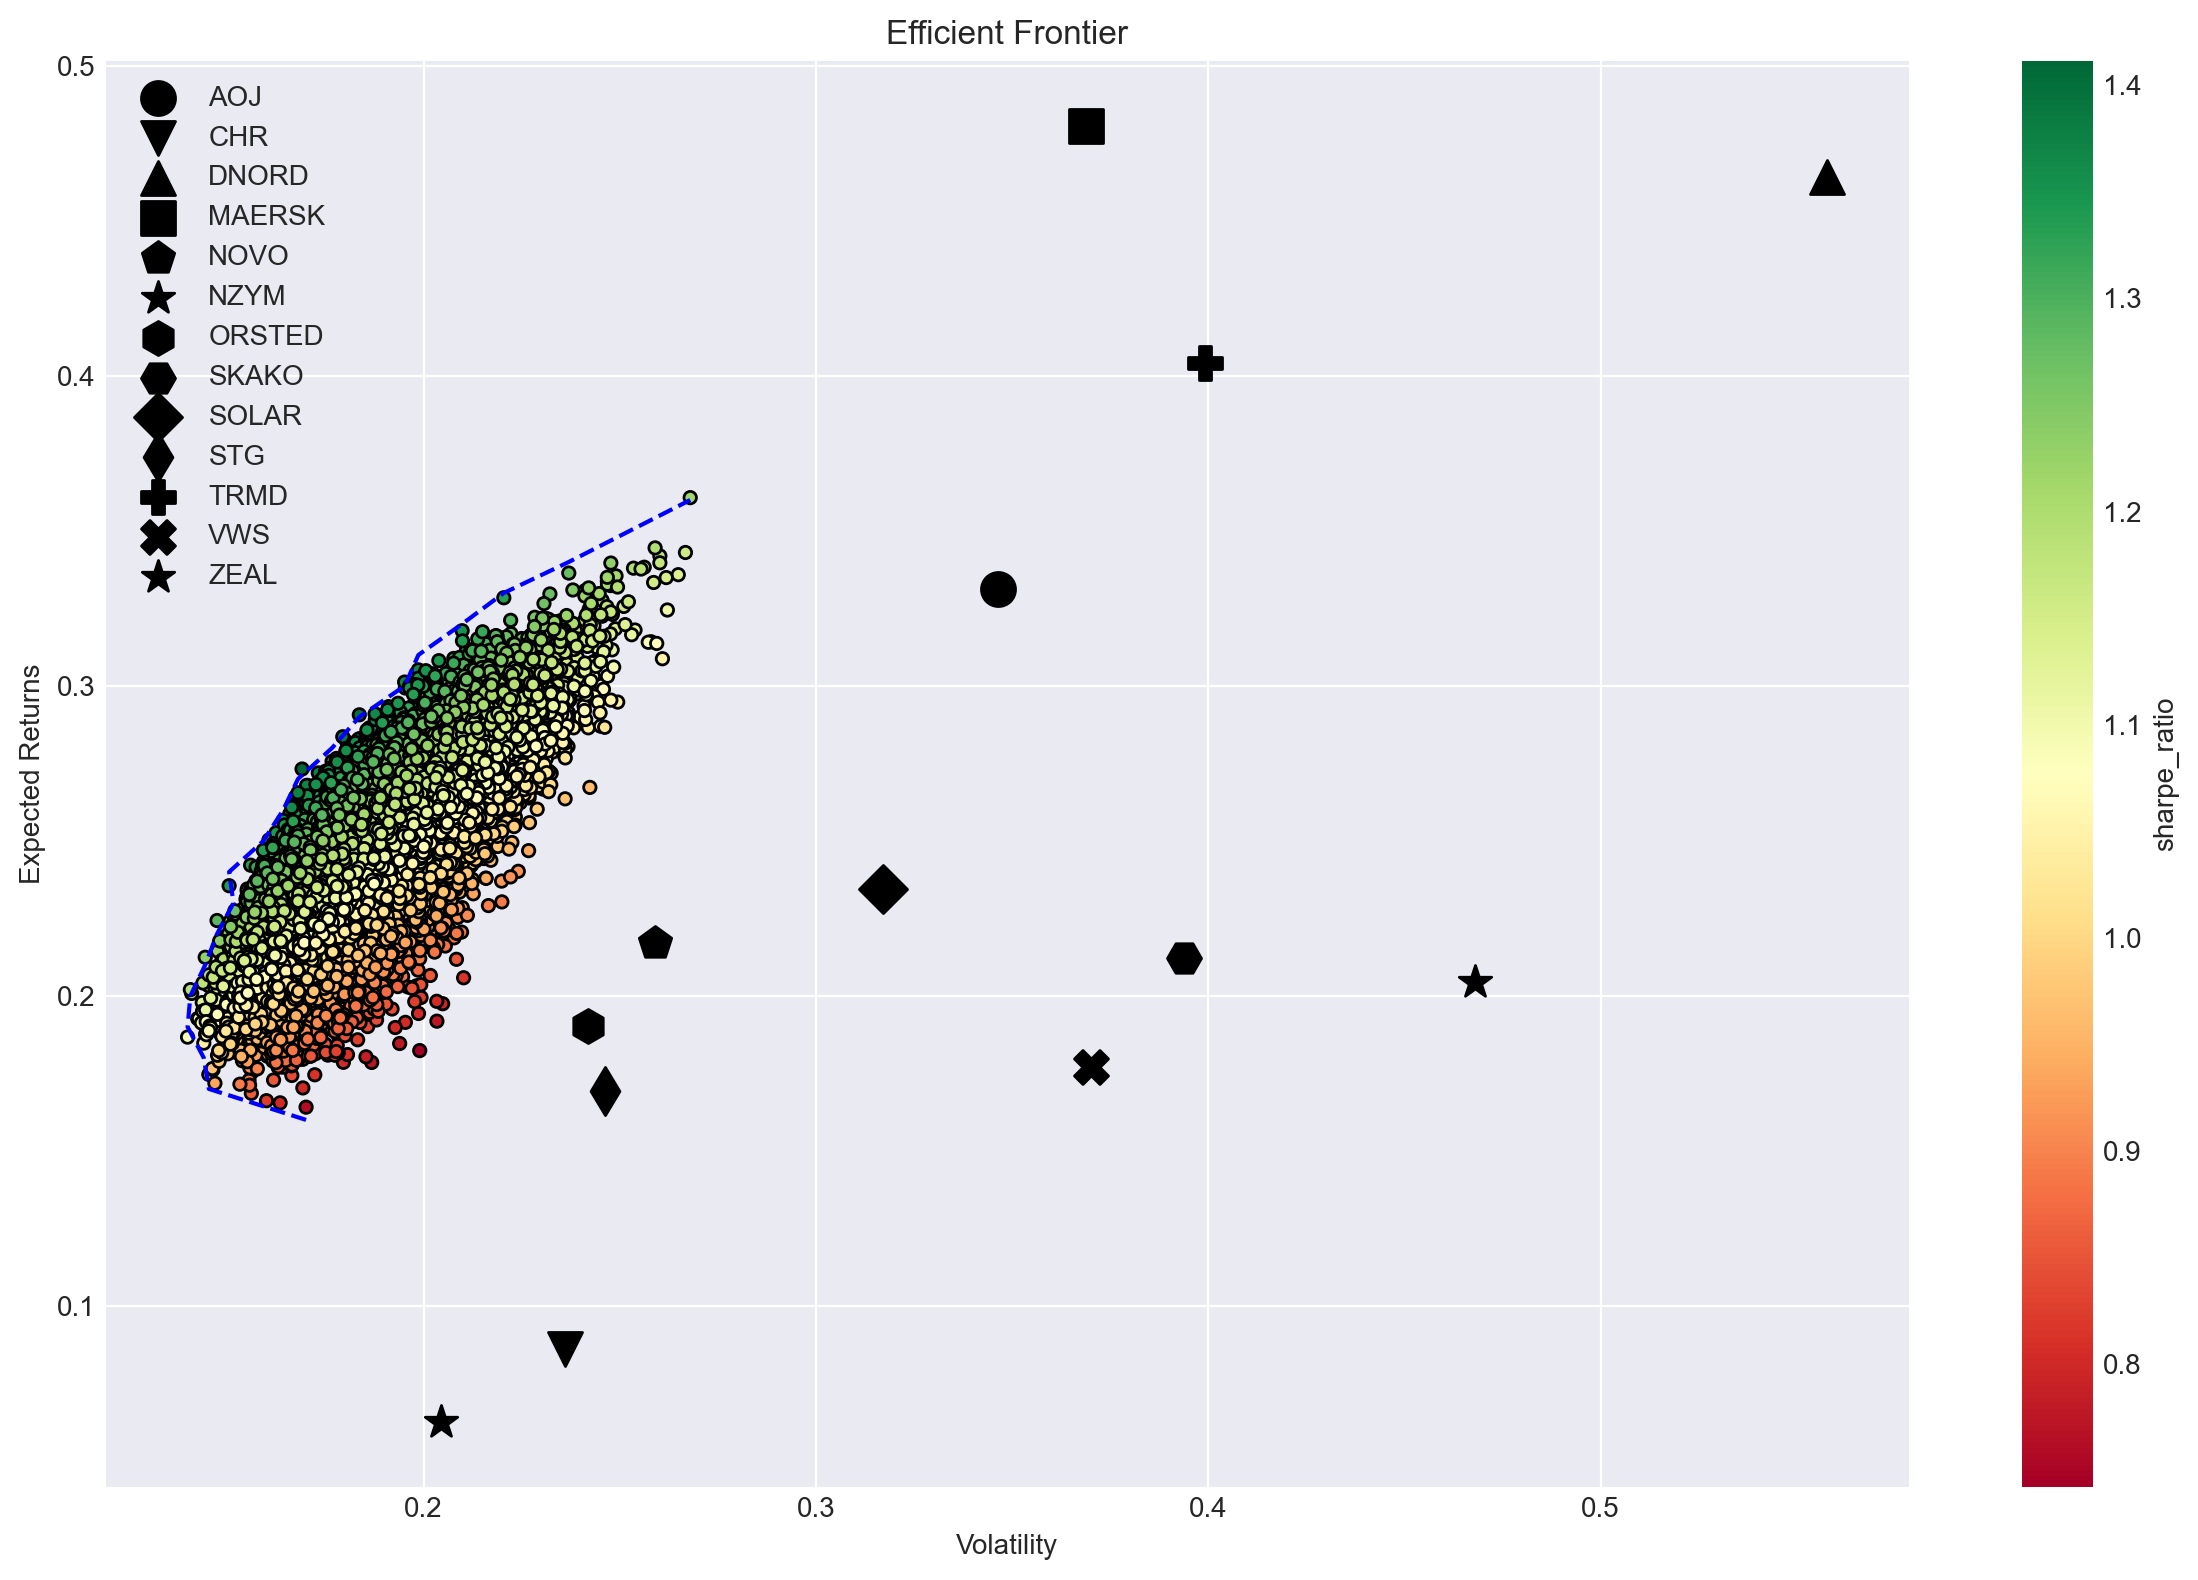

In [16]:
MARKS = ['o', 'v', '^', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '*']

fig, ax = plt.subplots(figsize=(12, 8))
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_matrix.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=stocks_names[asset_index])
ax.legend()

plt.tight_layout()
plt.show()

### Min variance portfolio

The term “Minimum Variance Portfolio” refers to the portfolio with the lowest variance. This portfolio can be obtained by solving the following quadratic programming model:

$$
\begin{align}
\min_{\mathbf{w}} \quad & \mathbf{w}^T \mathbf{\Sigma} \mathbf{w}  &\\
\text{s.t.: } \quad & \mathbf{w}^t \boldsymbol \mu &= \mathbf{r}^* \\
& \sum_{i=1}^N w_i &= 1
\end{align}
$$

In [17]:
rtns_range = np.linspace(-0.22, 0.50, 200)

In [18]:
efficient_portfolios = get_efficient_frontier(avg_returns, 
                                              cov_matrix, 
                                              rtns_range)

In [19]:
vols_range = [x['fun'] for x in efficient_portfolios]

In [20]:
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']

min_vol_portf = {'Return': min_vol_portf_rtn,
                 'Volatility': min_vol_portf_vol,
                 'Sharpe Ratio': ((min_vol_portf_rtn - danish_2y_yield) / 
                                  min_vol_portf_vol)}

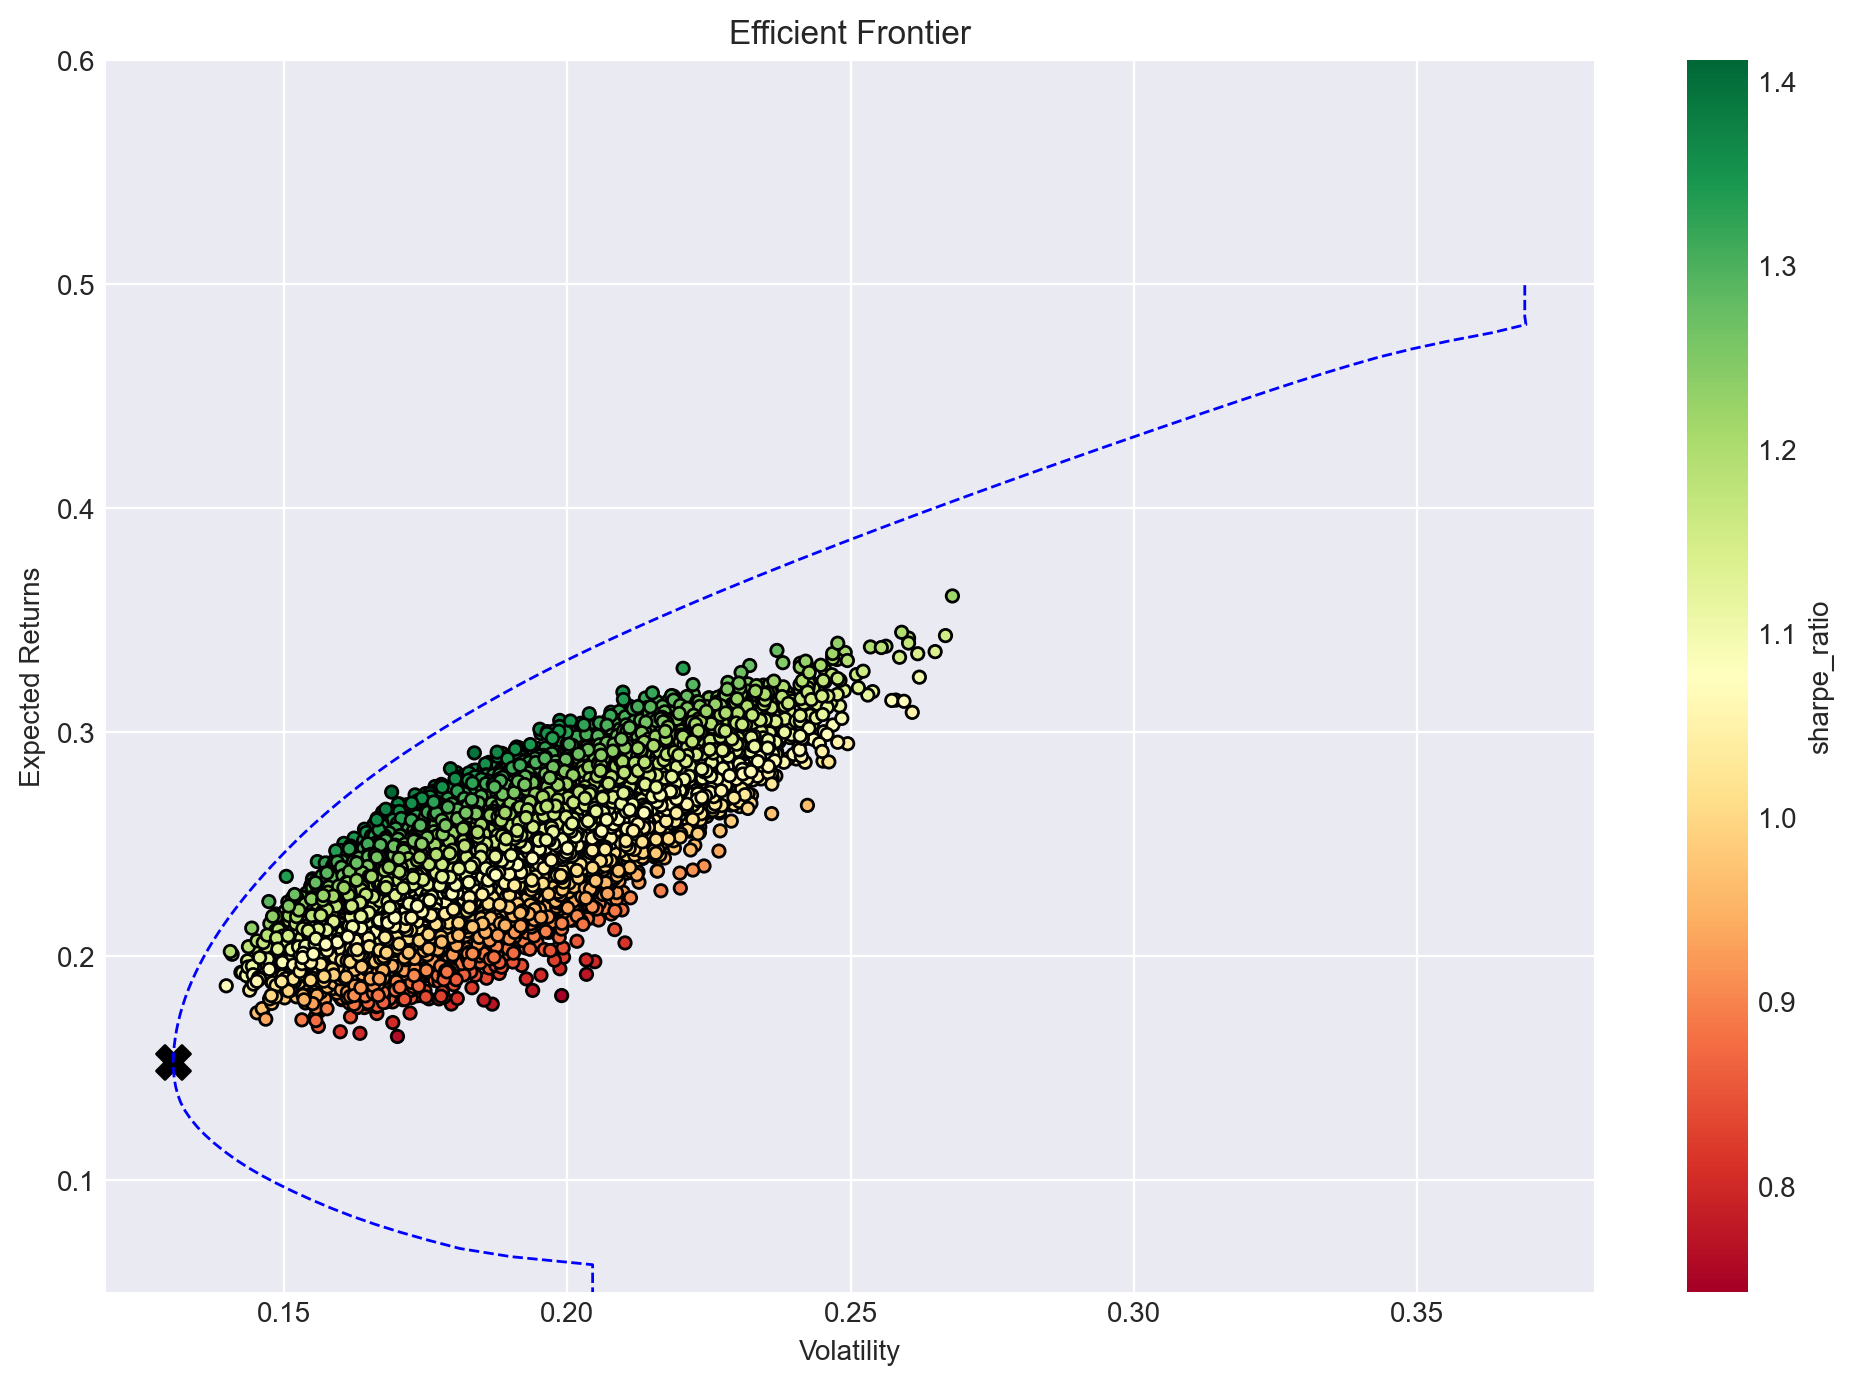

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth=1)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.scatter(x=min_vol_portf_vol, 
                y=min_vol_portf_rtn, 
                marker='X', 
                s=150, 
                color='black',
                label='MVP')

plt.ylim(0.05,0.6)
plt.show()

In [22]:
print('Minimum Volatility portfolio ----')
print('Performance')

for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(stocks_names, efficient_portfolios[min_vol_ind]['x']):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
Return: 15.27% Volatility: 13.05% Sharpe Ratio: 90.46% 
Weights
AOJ: 2.92% CHR: 12.83% DNORD: 0.00% MAERSK: 0.00% NOVO: 12.35% NZYM: 23.01% ORSTED: 19.10% SKAKO: 7.57% SOLAR: 1.13% STG: 21.08% TRMD: 0.00% VWS: 0.00% ZEAL: 0.00% 

### Include transaction costs

$$
\begin{align*}
\text{minimize} \quad & \mathbf{w}^T  \mathbf{\Sigma}\mathbf{w} \\
\text{subject to} \quad & \mathbf{w}^T \mathbf{\mu} \geq \mathbf{r} \\
& \mathbf{1}^T \mathbf{w}  \leq 1 \\
& \sum_{i} |w_i - w_{0, i}| \cdot c \leq T - C * 0.0044 \\
& \mathbf{x} \geq \mathbf{0}
\end{align*}
$$

where $T$ is the maximum amount that I'm willing to spend on trasaction costs, and $C$ is the initial capital.